# Imports

In [1]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
import sounddevice as sd
import cv2

# Load Data

In [3]:
xdf_path = "C:/Users/Admin/Documents/CurrentStudy/sub-P005/ses-S001/mobi/sub-P005_ses-S001_task-Social_run-001_mobi.xdf"

data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

Stream 2: Calculated effective sampling rate 119.9952 Hz is different from specified rate 90.0000 Hz.
Stream 6: Calculated effective sampling rate 249.9926 Hz is different from specified rate 500.0000 Hz.


['OpenSignals',
 'Tobii',
 'EGI NetAmp 0',
 'WebcamStream',
 'Stimuli_Markers',
 'Audio']

# Physio

In [4]:
PS = data[4]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['time'] = PS['time_stamps'] - PS['time_stamps'][0]

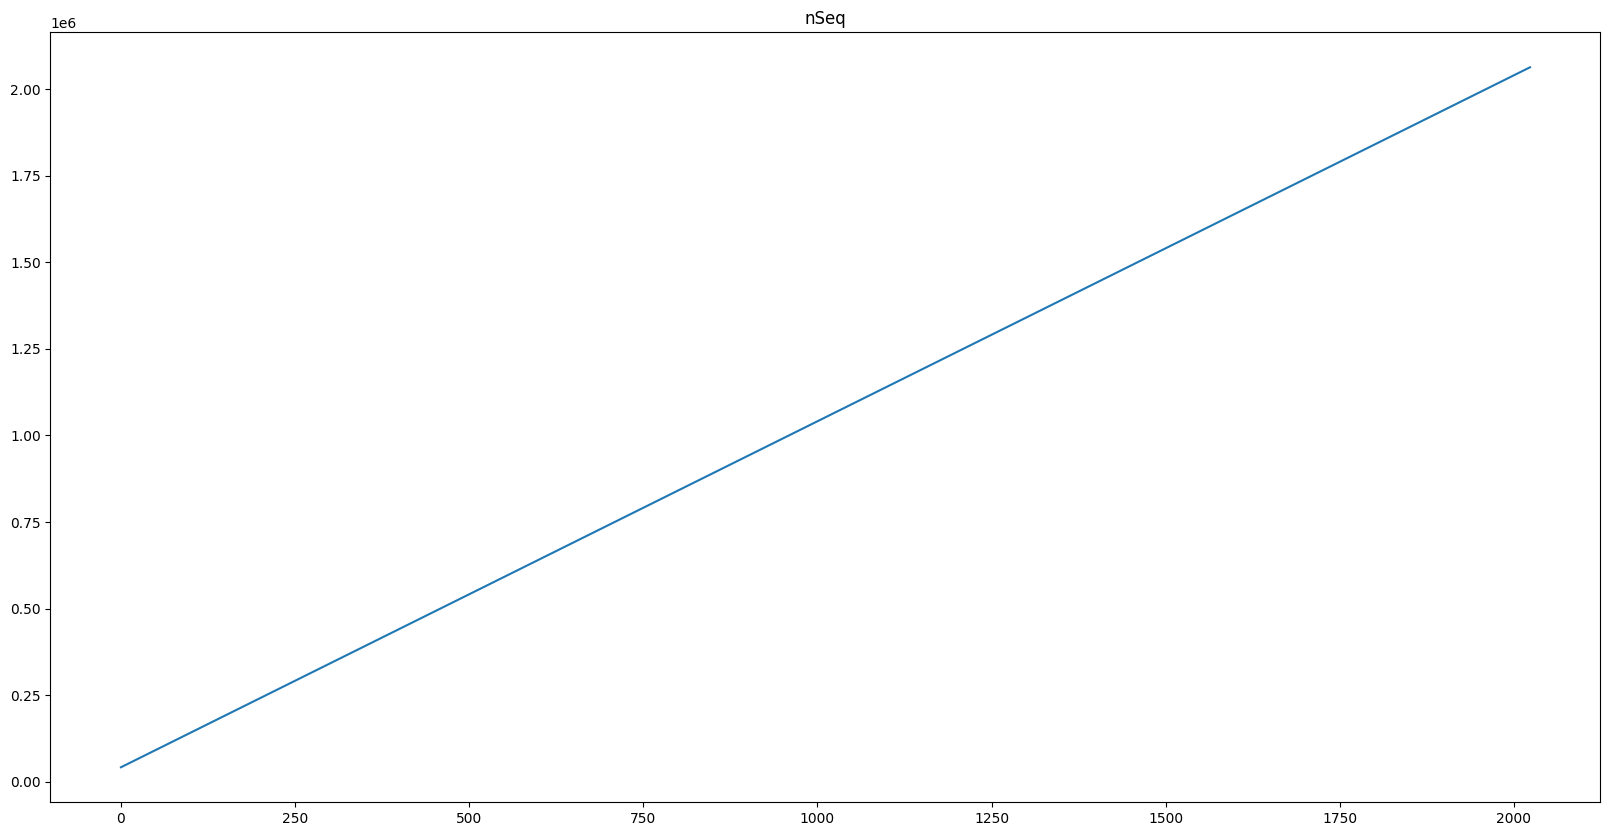

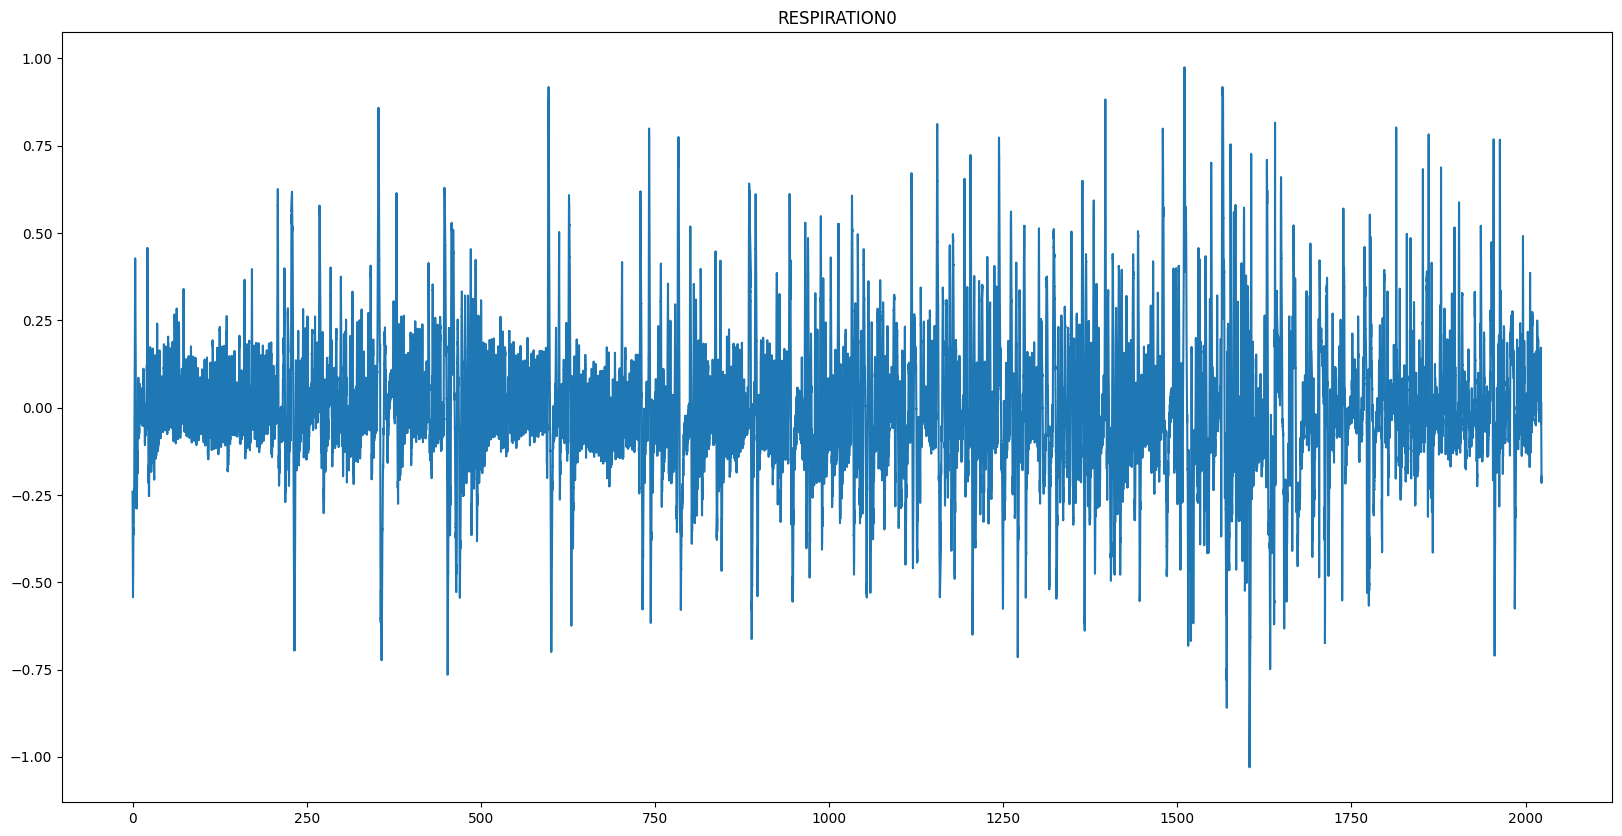

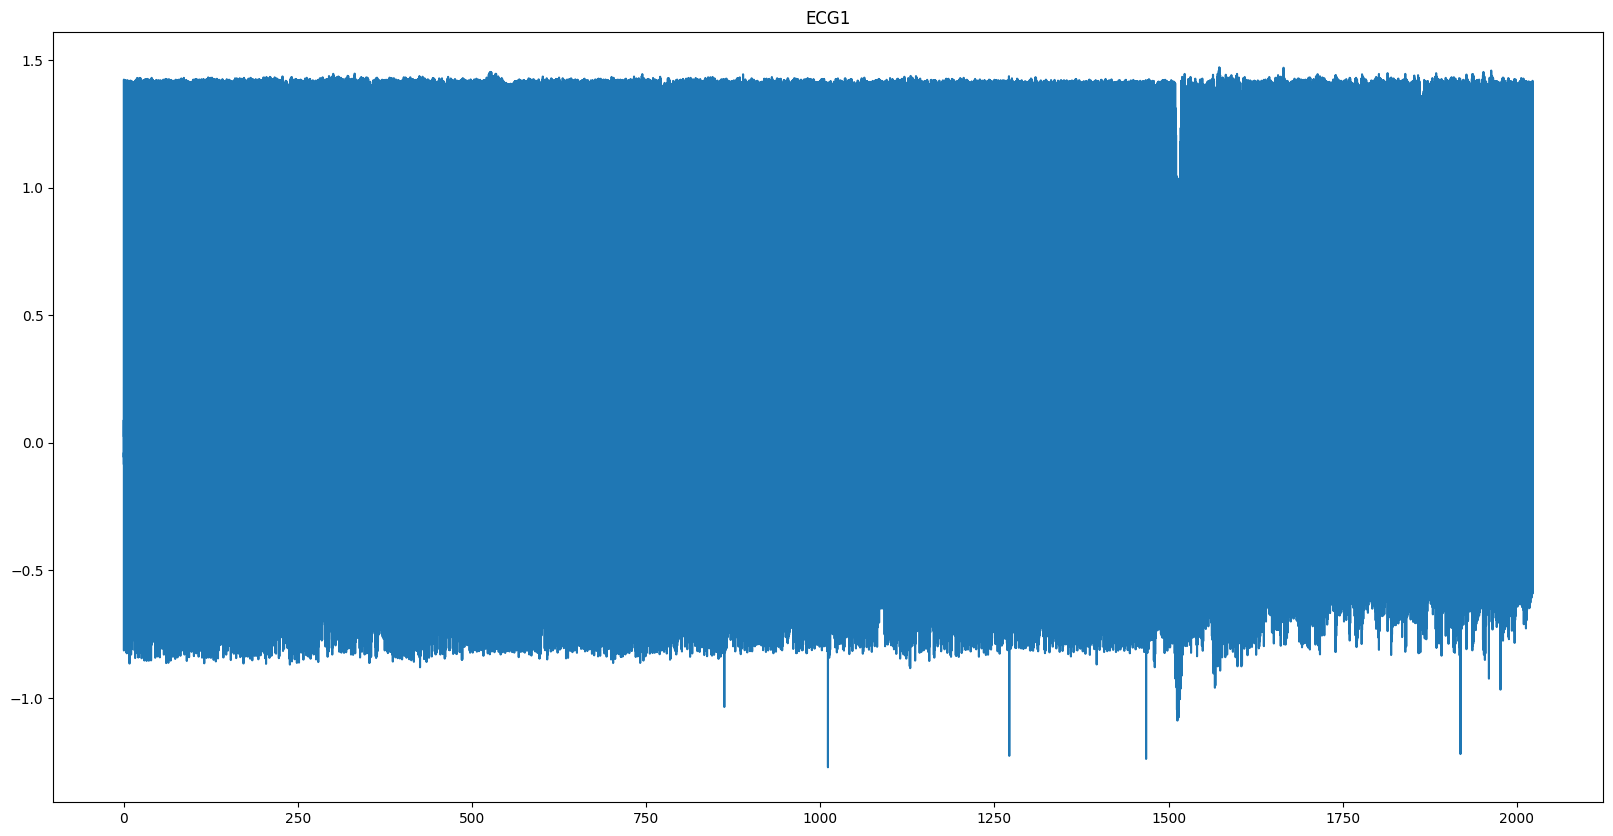

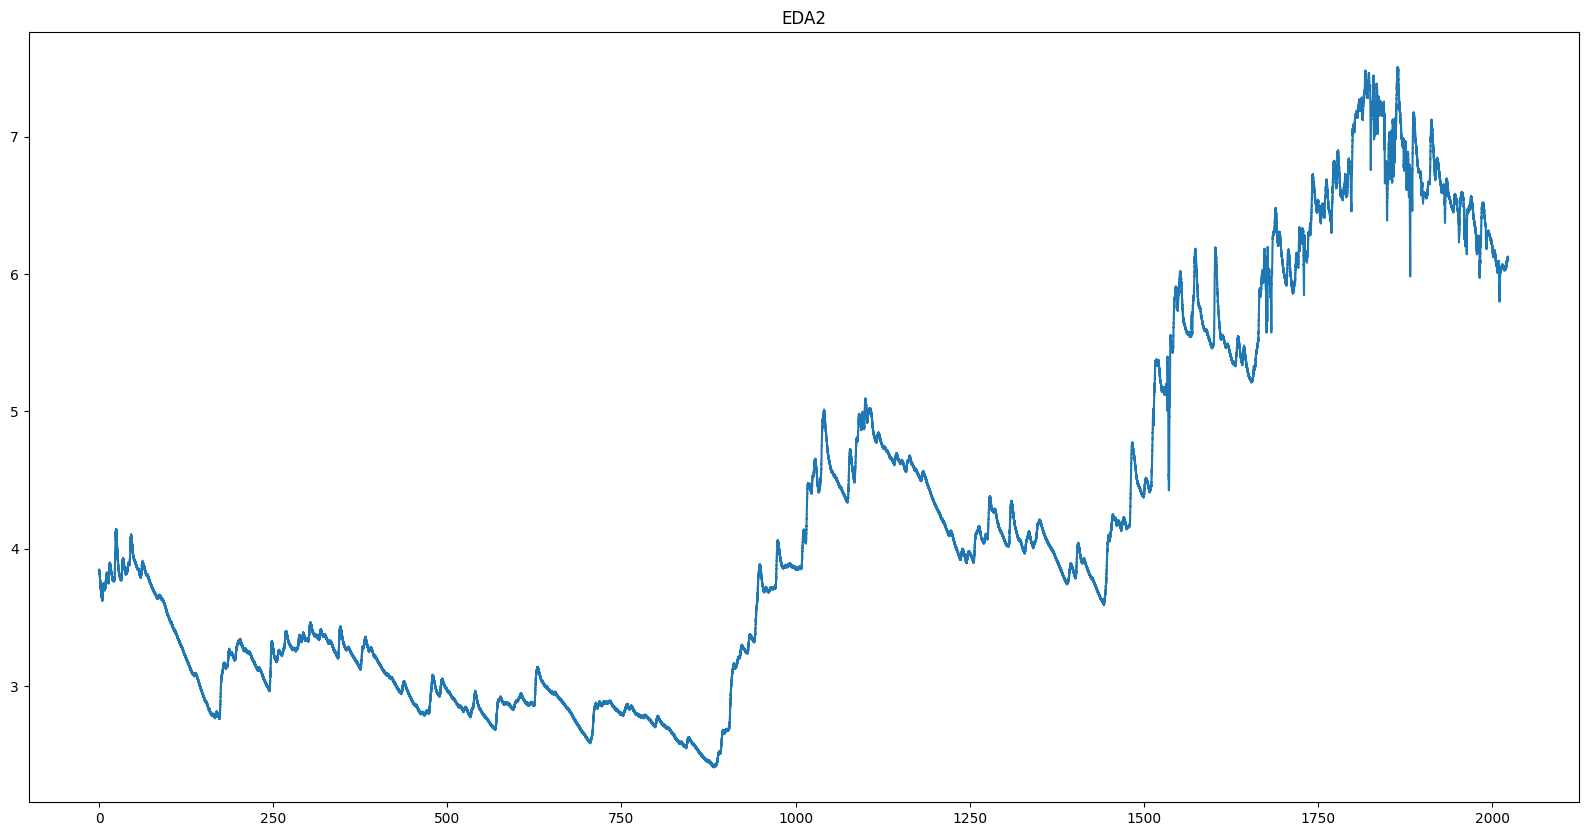

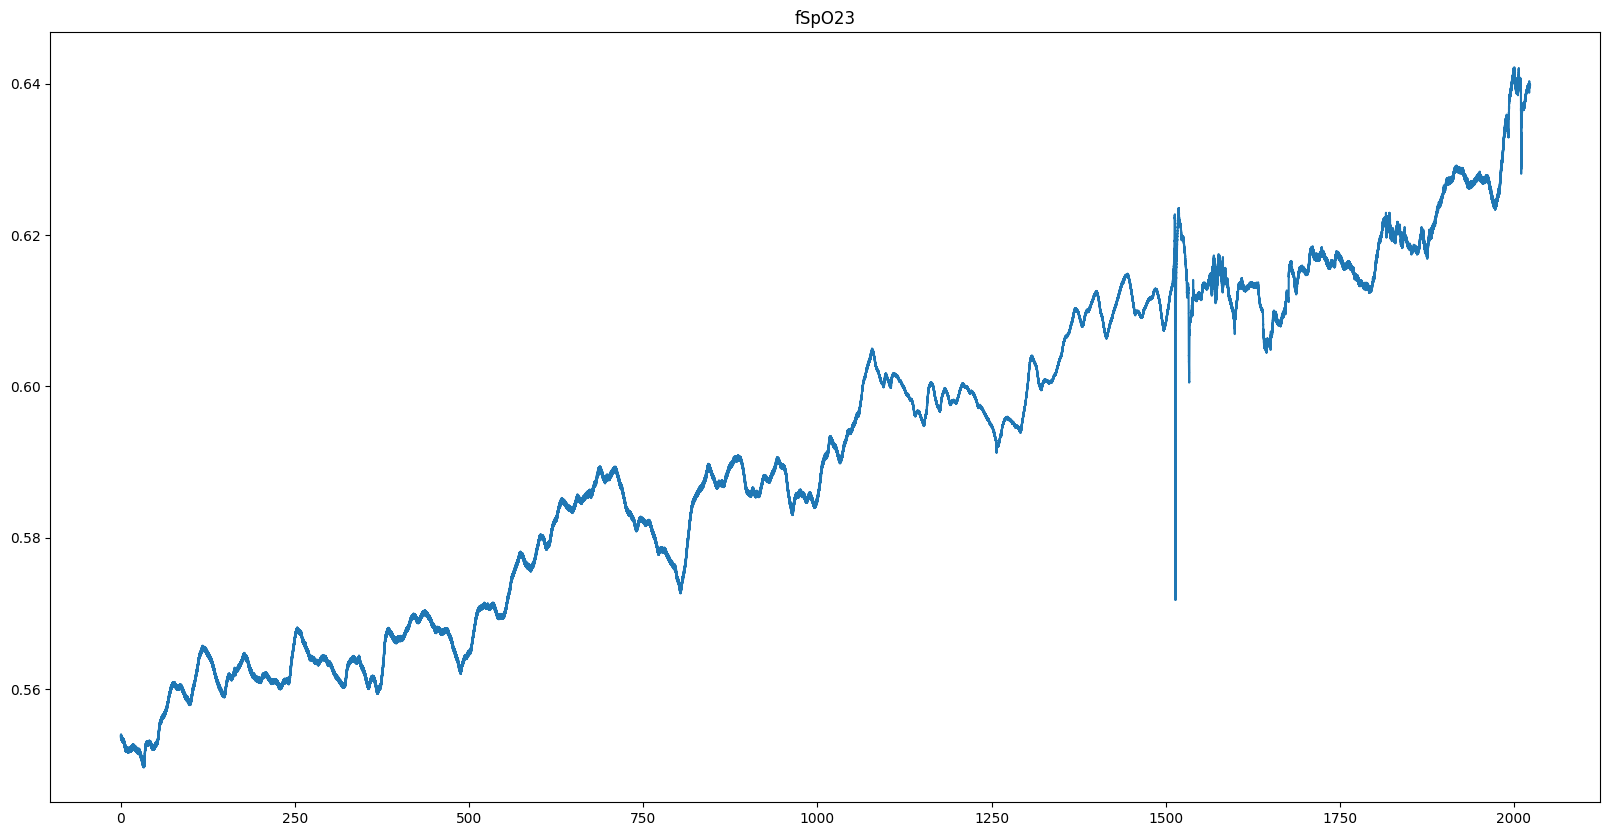

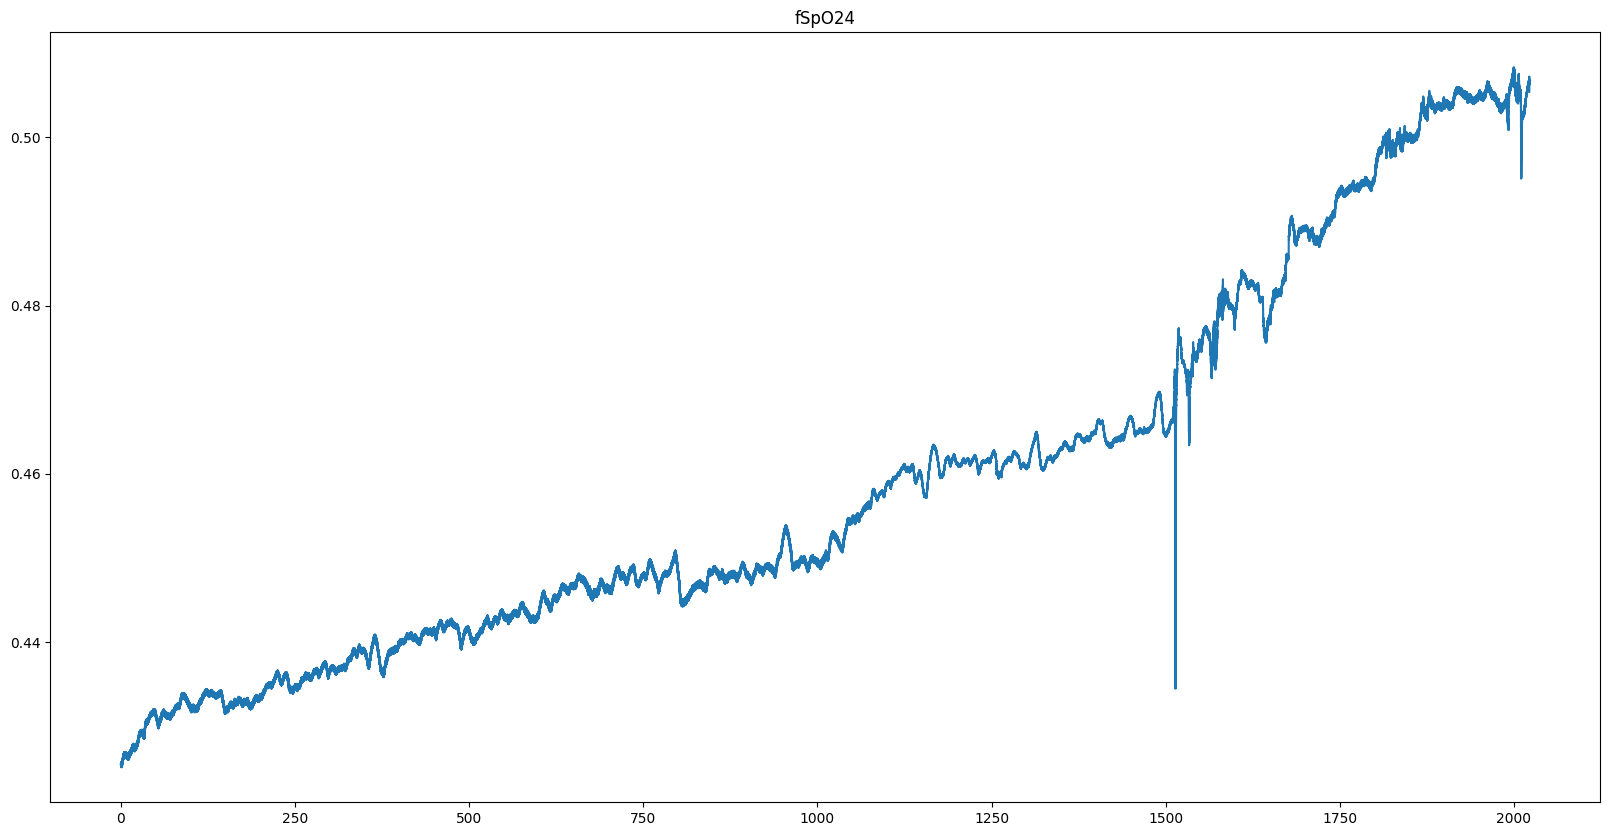

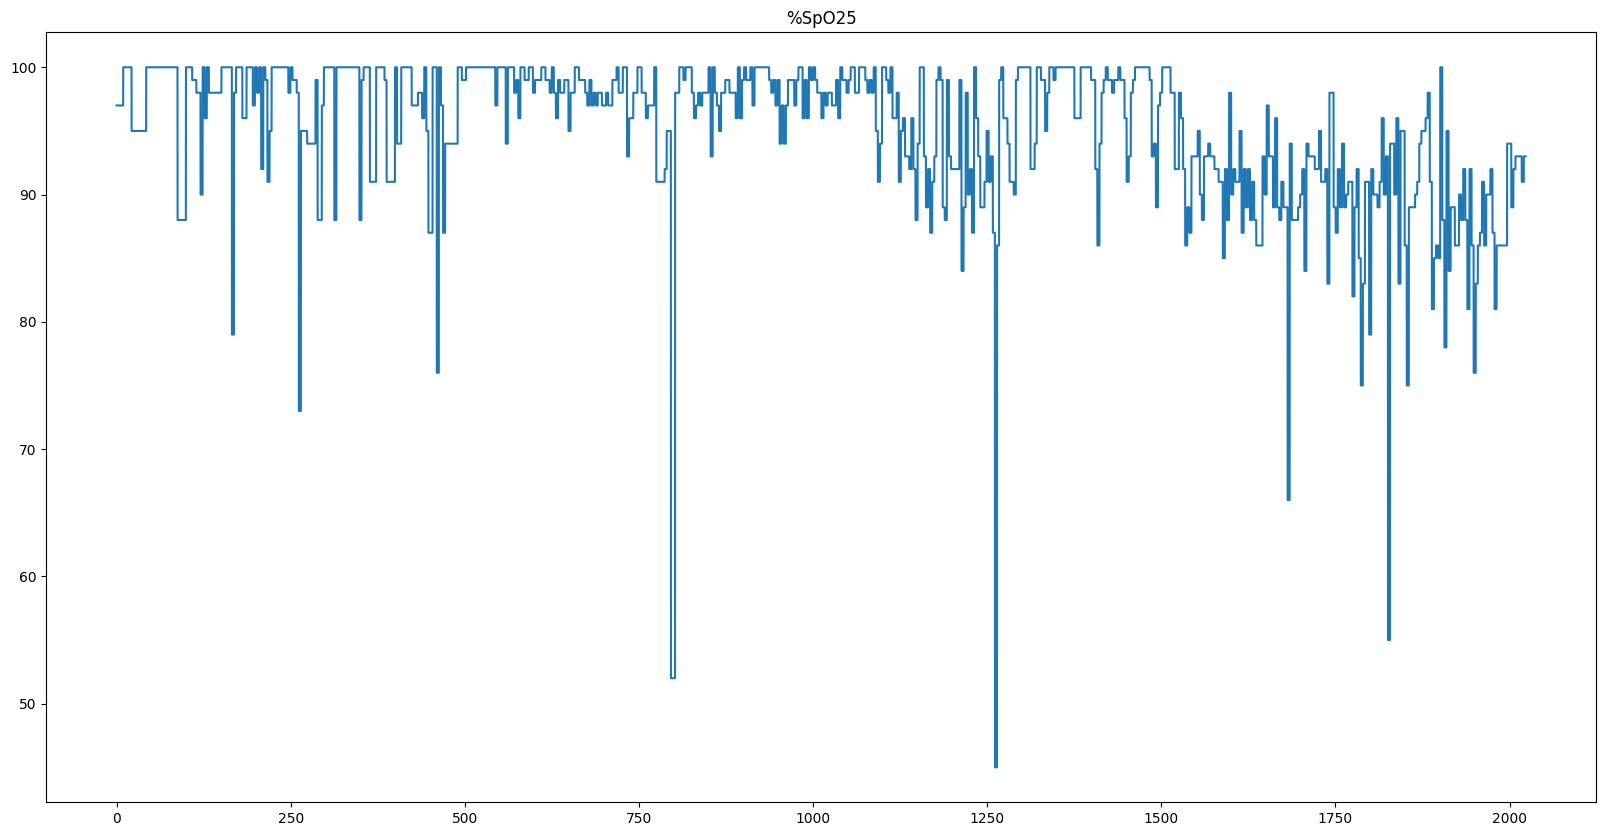

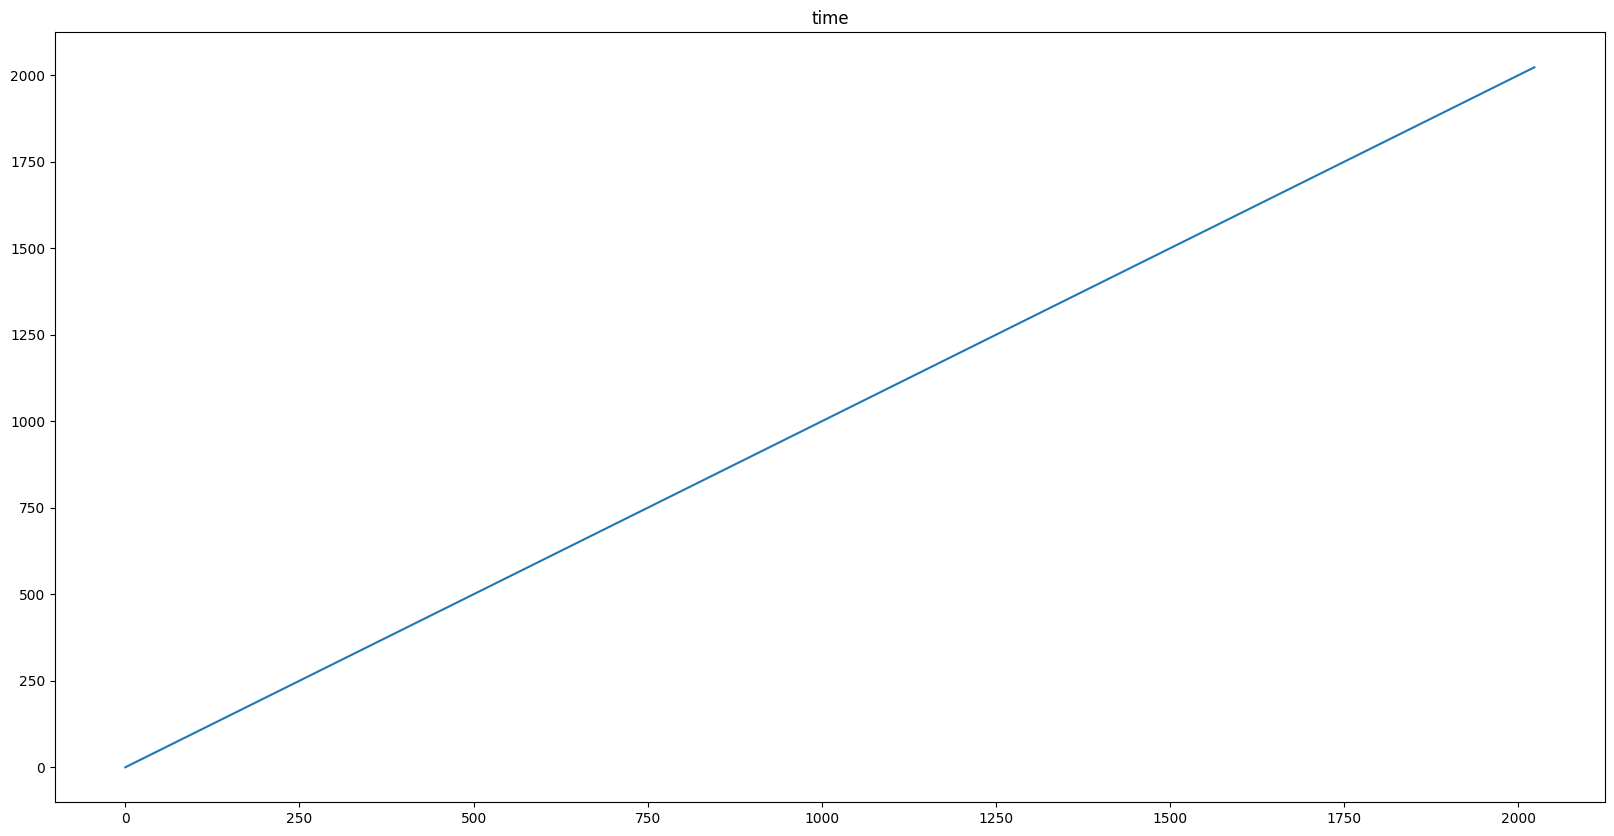

In [6]:
    
'''
# Plot every column in one plot
plt.figure(figsize=(20,10))
for col in ps_df.columns:
    plt.plot(ps_df['time'], ps_df[col])
plt.show()
'''
for col in ps_df.columns:
    plt.figure(figsize=(20,10))

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1200), col])
    plt.plot(ps_df['time'], ps_df[col])
    plt.title(col)
    plt.show()

In [31]:
ps_df.time.max()/60


24.509770766849396

# Stimulus

## Stimulus Trigger Duration - Story Listening

In [3]:
stim_dat = data[0]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    10: 'Onset_BirthMother',
    11: 'Offset_BirthMother', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    80: 'Onset_Glitter',
    81: 'Offset_Glitter',
}

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 4 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 4, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamps'] = stim_dat['time_stamps']
stim_df['time'] = stim_dat['time_stamps'] - stim_dat['time_stamps'][0]
stim_df.head(10)

,trigger,event,lsl_time_stamps,time
0,100,Onset_10second_rest,339430.267538,0.000000
1,1722614126,psychopy_time_stamp,339430.267550,0.000013
2,101,Offset_10second_rest,339440.284336,10.016798
3,1722614136,psychopy_time_stamp,339440.284345,10.016807
4,60,Onset_Tornado,339440.362039,10.094501
5,1722614136,psychopy_time_stamp,339440.362051,10.094513
6,61,Offset_Tornado,339603.605601,173.338063
7,1722614299,psychopy_time_stamp,339603.605611,173.338073
8,7,Bx_input,339609.753684,179.486146
9,6,Bx_input,339617.836658,187.569121


In [4]:
def get_secs_between_triggers(trigger1, trigger2):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

# Get a list of the story names using the events dict
#story_names = [x.split('_')[1] for x in list(events.values())[2:][::2]]
#story_names

story_onsets = list(events.keys())[2:][::2] #every other trigger is the offset
story_onsets

[10, 20, 30, 40, 50, 60, 70, 80]

In [5]:
files= [
    "../audio_files/audio_files/After_Searching_I_Found_and_Met_My_Birth_Mother.wav",
    "../audio_files/audio_files/Camp_Lose_A_Friend.wav",
    "../audio_files/audio_files/Frog_Dissection_Disaster.wav",
    "../audio_files/audio_files/I_Decided_To_Be_Myself_And_Won_A_Dance_Contest.wav",
    "../audio_files/audio_files/I_Fully_Embarrassed_Myself_In_Zoom_Class1.wav",
    "../audio_files/audio_files/Left_Home_Alone_in_a_Tornado.wav",
    "../audio_files/audio_files/The_Birthday_Party_Prank.wav",
    "../audio_files/audio_files/My_Dad_Saw_Me_Wearing_Glitter_At_School.wav"
]


durations = pd.DataFrame({
    'trigger':story_onsets,
    'story':[events[x] for x in story_onsets],
    'lsl_duration': [get_secs_between_triggers(x+1, x) for x in story_onsets],
    'audiofile_duration': [wave.open(x).getnframes()/wave.open(x).getframerate() for x in files] #duration of audio file is number of frames divided by the frame rate.
})

durations['difference(sec)'] = durations['audiofile_duration'] - durations['lsl_duration']
durations

,trigger,story,lsl_duration,audiofile_duration,difference(sec)
0,10,Onset_BirthMother,157.745044,157.726104,-0.018939
1,20,Onset_CampFriend,152.937353,152.838063,-0.099290
2,30,Onset_FrogDissection,124.361157,124.344813,-0.016344
3,40,Onset_DanceContest,138.335716,138.318729,-0.016987
4,50,Onset_ZoomClass,98.378069,98.359854,-0.018215
5,60,Onset_Tornado,163.243562,163.227583,-0.015979
6,70,Onset_BirthdayParty,160.231821,160.215313,-0.016509
7,80,Onset_Glitter,158.391881,158.380208,-0.011673


## Stimulus Triggers - Social Script

In [23]:
stim_dat = data[4]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)

events = {100: 'Conversation_start', 
          101: 'Conversation_end'}

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 4 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 4, 'event'] = 'psychopy_time_stamp'
stim_df['time'] = stim_dat['time_stamps'] - stim_dat['time_stamps'][0]

conversation_onset_stim = stim_df.loc[stim_df.event == 'Conversation_start', 'time'].values[0]
conversation_offset_stim = stim_df.loc[stim_df.event == 'Conversation_end', 'time'].values[0]
stim_df


,trigger,event,time
0,100,Conversation_start,0.000000
1,1722616294,psychopy_time_stamp,0.000011
2,101,Conversation_end,301.501762
3,1722616595,psychopy_time_stamp,301.501773


# Linking Microphone Data to Video Data

In [9]:
mic_data = data[5]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['lsl_time_stamps'] = mic_data['time_stamps']
mic_df['time'] = mic_data['time_stamps'] - mic_data['time_stamps'][0]
mic_df.head(100)

,int_array,bytestring,lsl_time_stamps,time
0,-771,b'\xfd\xfc\xff\xff',341579.658152,0.000000
1,-583,b'\xb9\xfd\xff\xff',341579.658174,0.000023
2,-375,b'\x89\xfe\xff\xff',341579.658197,0.000045
3,-154,b'f\xff\xff\xff',341579.658220,0.000068
4,32,b' \x00\x00\x00',341579.658242,0.000091
...,...,...,...,...
95,2048,b'\x00\x08\x00\x00',341579.660306,0.002154
96,2118,b'F\x08\x00\x00',341579.660329,0.002177
97,2053,b'\x05\x08\x00\x00',341579.660351,0.002200
98,1927,b'\x87\x07\x00\x00',341579.660374,0.002222


In [50]:
#Find rows in mic_df that roughly matchs the conversation start and end
conversation_mic = mic_df.loc[(mic_df.time > conversation_onset_stim) & (mic_df.time < conversation_offset_stim + 1000)]
end = mic_df.loc[mic_df.time > conversation_offset_stim ]
sd.play(end['int_array'].values, 44100)

In [36]:
conversation_mic

,int_array,bytestring,lsl_time_stamps,time
1,-583,b'\xb9\xfd\xff\xff',341579.658174,0.000023
2,-375,b'\x89\xfe\xff\xff',341579.658197,0.000045
3,-154,b'f\xff\xff\xff',341579.658220,0.000068
4,32,b' \x00\x00\x00',341579.658242,0.000091
5,192,b'\xc0\x00\x00\x00',341579.658265,0.000113
...,...,...,...,...
13296183,-28,b'\xe4\xff\xff\xff',341881.159813,301.501661
13296184,-23,b'\xe9\xff\xff\xff',341881.159836,301.501684
13296185,-20,b'\xec\xff\xff\xff',341881.159858,301.501706
13296186,-20,b'\xec\xff\xff\xff',341881.159881,301.501729


In [33]:
start = 4145400
mic_start_time = mic_df.loc[start, 'time']
stop = 4806900
mic_stop_time = mic_df.loc[stop, 'time']


sd.play(mic_df.loc[(mic_df.time > mic_start_time) & (mic_df.time < mic_stop_time), 'int_array'], 44100)

Now lets open the video frames

In [16]:
mic_start_time

94.0002845711424

In [18]:
# Identify the frames we're interested in
cam_data = data[3]
#cam_df = pd.DataFrame(cam['time_series'], columns=['frame'])
#cam_df['lsl_timestamps'] = cam['time_stamps']
#cam_df['time'] = cam_df['lsl_timestamps'] - cam_df['lsl_timestamps'][0]
cam_data['time_series'][0]
frame_nums = [int(i[0]) for i in cam_data['time_series']]
time_pre = [float(i[1]) for i in cam_data['time_series']]
time_evnt_ms = [float(i[2]) for i in cam_data['time_series']]
time_post = [float(i[3]) for i in cam_data['time_series']]


cam_df = pd.DataFrame({'frame_num': frame_nums, 
                    'time_pre': time_pre, 
                    'cap_time_ms': time_evnt_ms,
                    'time_post': time_post,
                    'lsl_time_stamp': cam_data['time_stamps']})



cam_df['frame_time_sec'] = (cam_df.cap_time_ms - cam_df.cap_time_ms[0])/1000
cam_df['lsl_time_sec'] = cam_df.lsl_time_stamp - cam_df.lsl_time_stamp[0]
cam_df

,frame_num,time_pre,cap_time_ms,time_post,lsl_time_stamp,frame_time_sec,lsl_time_sec
0,1,1.722616e+09,2.533753e+08,1.722616e+09,341592.619618,0.000000,0.000000
1,2,1.722616e+09,2.533754e+08,1.722616e+09,341592.652952,0.033333,0.033334
2,3,1.722616e+09,2.533754e+08,1.722616e+09,341592.686285,0.066667,0.066667
3,4,1.722616e+09,2.533754e+08,1.722616e+09,341592.719619,0.100000,0.100001
4,5,1.722616e+09,2.533755e+08,1.722616e+09,341592.752952,0.133333,0.133334
...,...,...,...,...,...,...,...
9419,9420,1.722617e+09,2.536893e+08,1.722617e+09,341906.588479,313.966667,313.968861
9420,9421,1.722617e+09,2.536893e+08,1.722617e+09,341906.621813,314.000000,314.002195
9421,9422,1.722617e+09,2.536894e+08,1.722617e+09,341906.655146,314.033333,314.035528
9422,9423,1.722617e+09,2.536894e+08,1.722617e+09,341906.688480,314.066667,314.068862


In [19]:
cam_df['time'] = cam_df['lsl_time_sec'].apply(lambda x: round(x, 3))
cam_df

,frame_num,time_pre,cap_time_ms,time_post,lsl_time_stamp,frame_time_sec,lsl_time_sec,time
0,1,1.722616e+09,2.533753e+08,1.722616e+09,341592.619618,0.000000,0.000000,0.000
1,2,1.722616e+09,2.533754e+08,1.722616e+09,341592.652952,0.033333,0.033334,0.033
2,3,1.722616e+09,2.533754e+08,1.722616e+09,341592.686285,0.066667,0.066667,0.067
3,4,1.722616e+09,2.533754e+08,1.722616e+09,341592.719619,0.100000,0.100001,0.100
4,5,1.722616e+09,2.533755e+08,1.722616e+09,341592.752952,0.133333,0.133334,0.133
...,...,...,...,...,...,...,...,...
9419,9420,1.722617e+09,2.536893e+08,1.722617e+09,341906.588479,313.966667,313.968861,313.969
9420,9421,1.722617e+09,2.536893e+08,1.722617e+09,341906.621813,314.000000,314.002195,314.002
9421,9422,1.722617e+09,2.536894e+08,1.722617e+09,341906.655146,314.033333,314.035528,314.036
9422,9423,1.722617e+09,2.536894e+08,1.722617e+09,341906.688480,314.066667,314.068862,314.069


A goal here is to identify timestamps in the microphone data and their corresponding frames in the video data

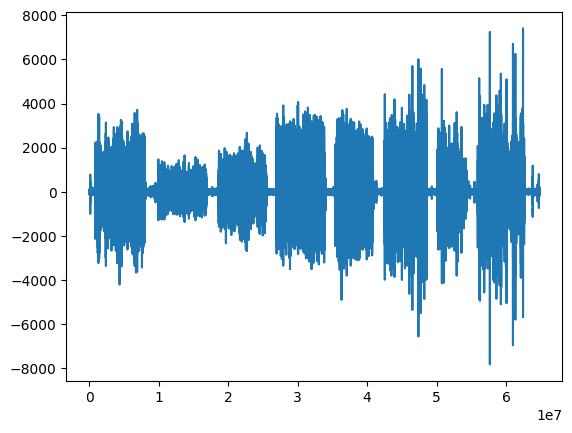

In [10]:
plt.plot(mic_df['int_array'])